In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

rng  = np.random.default_rng(1234)

In [23]:

def u(t):
    return 1
    return np.sin(0.1*t)+1

delta = 0.5
x0 = 20.
c = 5.

def temperature_mass_system(t,x):
    # delta, x0, c = args
    return -delta*(x-x0) + c*u(t)
    

In [24]:
t = np.arange(0,100.1,0.1)
sol = solve_ivp(
    temperature_mass_system,
    t_span=[t[0],t[-1]],
    t_eval=t,
    y0=[15.],
    method='LSODA'
)

In [25]:
t_true = sol.t
u_true = np.array([u(ti) for ti in t_true])
x_true = sol.y[0]
xdot_true = temperature_mass_system(t_true, x_true)

In [26]:
var = 0.5
t_train = t_true[::10]
u_train = np.array([u(ti) for ti in t_train])
x_train = x_true[::10] + var*rng.normal(0,1,x_true[::10].shape)

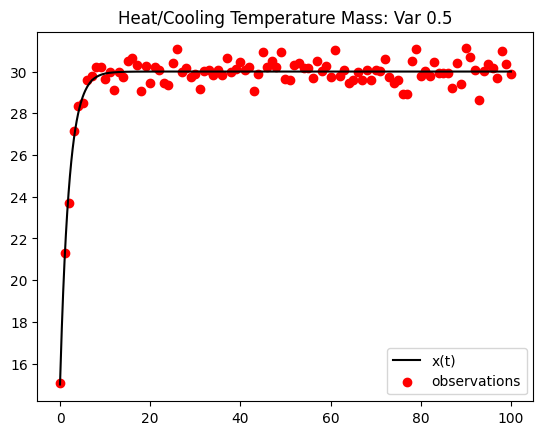

In [27]:
plt.plot(sol.t,sol.y[0], label='x(t)',c='black')
plt.scatter(t_train, x_train, label='observations',c='red')
plt.title(f"Heat/Cooling Temperature Mass: Var {var}")
plt.legend()
plt.show()


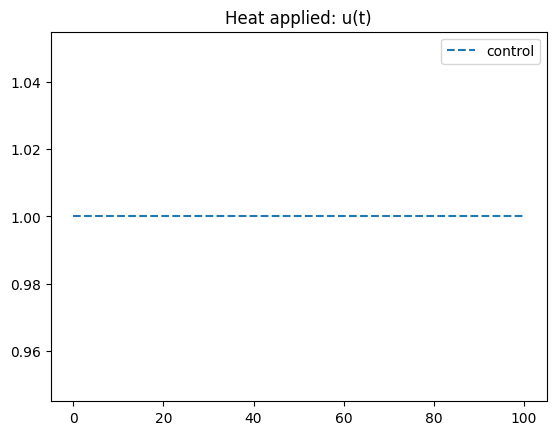

In [28]:
plt.plot(t,[u(ti) for ti in t], linestyle='--',label='control')
plt.title("Heat applied: u(t)")
plt.legend()
plt.show()

# Kernel Method

In [29]:
# just try out of the box opt first
from sklearn.metrics.pairwise import rbf_kernel
from scipy.signal import savgol_filter
from scipy.optimize import minimize

In [30]:
x_u_train = np.vstack([x_train,u_train]).T
K_g = rbf_kernel(x_u_train,x_u_train,gamma=1)

In [31]:
K_f = rbf_kernel(x_train.reshape(-1,1),x_train.reshape(-1,1),gamma=1)
x_u_train = np.vstack([x_train,u_train]).T
K_g = rbf_kernel(x_u_train,x_u_train,gamma=1)

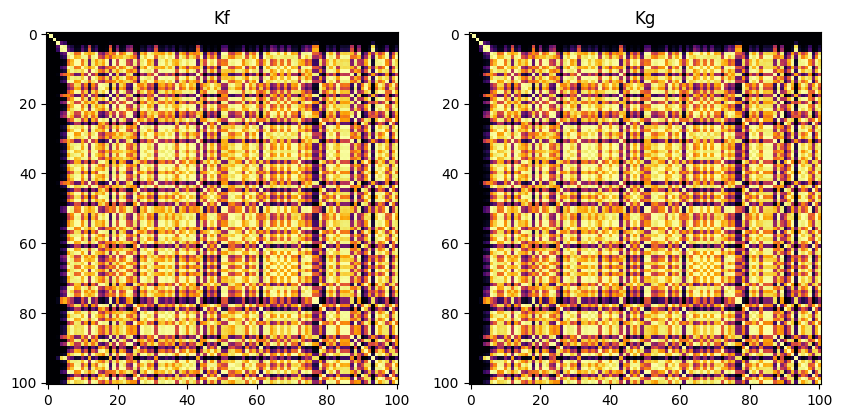

In [32]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].imshow(K_f,cmap='inferno')
axs[0].set_title("Kf")

axs[1].imshow(K_g, cmap='inferno')
axs[1].set_title("Kg")
plt.show()

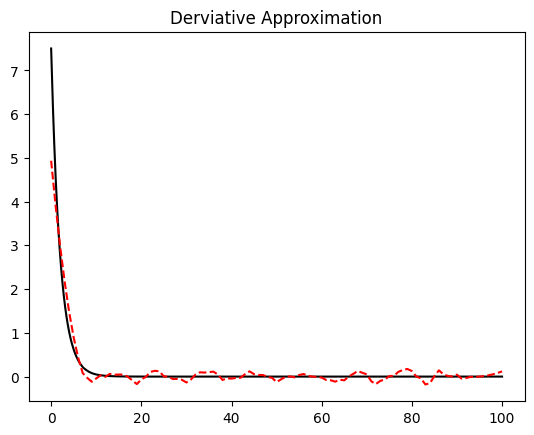

In [47]:
xdot_approx = savgol_filter(x_train, window_length=15,polyorder=3,deriv=1,delta=t_train[1]-t_train[0])

plt.plot(t_true,xdot_true, label="True derviative",c='black')
plt.plot(t_train,xdot_approx,linestyle='--',label='approx',c='red')
plt.title("Derviative Approximation")
plt.show()

In [34]:
N = len(x_train)
lam_f = 1.
lam_g = 1.
def loss_k(params):
    alpha = params[:N]
    beta = params[N:]

    fk = K_f@alpha
    gk = K_g@beta

    resid = xdot_approx - fk*(x_train.flatten() - gk)
    reg = lam_f/2*alpha.T@K_f@alpha + lam_g/2*beta.T@K_g@beta
    loss = np.mean(resid**2) + reg
    return loss


In [35]:
x0_opt = np.zeros(2*N)
sol_opt = minimize(loss_k,x0_opt,method='L-BFGS-B')

In [36]:
alpha_star = sol_opt.x[:N]
beta_star = sol_opt.x[N:]


In [37]:
alpha_star.shape, beta_star.shape

((101,), (101,))

In [38]:
def f_star(x):
    Kf = rbf_kernel(x,x_train.reshape(-1,1),gamma=1)
    return Kf@alpha_star

def g_star(x,u):
    input = np.vstack([x,u]).T
    Kg = rbf_kernel(input, x_u_train)
    return Kg@beta_star

In [39]:
f_out = f_star(x_train.reshape(-1,1))
g_out = g_star(x_train,u_train)

# xdot_k_approx = f_out*(x_train - g_out)

In [40]:
f_true = np.array([-delta]*len(x_true))
g_true = -delta*(x_true - x0) + c*np.array([u(ti) for ti in t])

In [41]:
f_true.shape

(1001,)

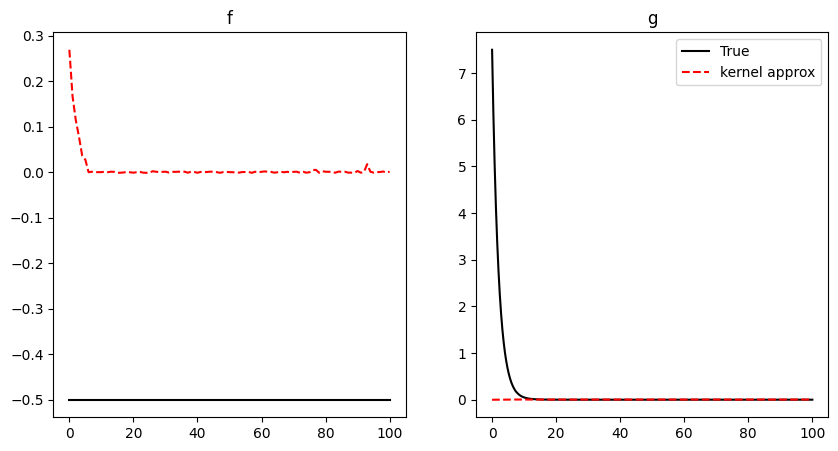

In [53]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].plot(t,f_true,c='black')
axs[0].plot(t_train, f_out,linestyle='--',c='red')
axs[0].set_title("f")


axs[1].plot(t,g_true,c='black', label='True')
axs[1].plot(t_train, g_out,linestyle='--',c='red', label='kernel approx')
axs[1].set_title("g")

plt.legend()
plt.show()